In [0]:
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

In [0]:
import os
import sys 
import numpy as np
import pandas as pd

import lightgbm as lgb
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

In [0]:
!head ./dummy_data.csv

駅名,建物構造,徒歩分,専有面積,間取り,部屋数,築年,所在階,成約価格
大門,SRC,5,66,K,1,200003,33,81000000
汐留,RC,8,55,R,1,201708,16,81600000
赤坂見附,SRC,4,60,DK,1,198300,30,77600000
六本木一丁目,RC,8,53,DK,1,201204,44,75500000
表参道,RC,6,35,R,1,200510,2,47700000
外苑前,SRC,2,47,K,1,200607,13,71600000
表参道,SRC,6,48,K,2,200610,4,69800000
溜池山王,RC,5,146,K,3,200002,6,224900000
六本木,SRC,4,80,DK,2,198010,3,76900000


In [0]:
# data load
data = pd.read_csv("dummy_data.csv")
#train test split
train_data, test_data = train_test_split(data, test_size=5000, random_state=0)
print(f'num of train data : {len(train_data)}')
print(f'num of test data : {len(test_data)}')

num of train data : 35000
num of test data : 5000


In [0]:
# 特徴作成
def create_feature(data):
    feature = data[["駅名", "建物構造", "徒歩分", "専有面積", "間取り", "部屋数", "築年", "所在階"]].copy()
    feature["築年"] = pd.to_datetime(feature["築年"].fillna(0).astype(int).astype(str), format="%Y%m", errors="coerce")
    feature["築年"] = (feature["築年"] - pd.to_datetime("1900-01-01")).dt.total_seconds() #日付を連続値に変換
    feature["所在階"] = feature["所在階"].str.replace('B', '-').astype(int) #地下表記を数字に変換
    
    cat_cols = ['駅名', '建物構造', '間取り']
    feature[cat_cols] = feature[cat_cols].astype("category")
    feature = feature.rename(columns={'駅名': 'station', '建物構造': 'structure', '徒歩分': 'walk_min', '専有面積': 'area', '間取り': 'room_type', '部屋数': 'room', '築年': 'age', '所在階': 'floor'})
    
    return feature
    
X_train = create_feature(train_data)
y_train = train_data["成約価格"]

In [0]:
X_train.head()

,station,structure,walk_min,area,room_type,room,age,floor
17714,赤坂見附,RC,8,85,K,1,3.316205e+09,2
21179,目黒,RC,1,55,K,3,3.600202e+09,7
27460,田町,SRC,14,86,R,2,2.182550e+09,7
22341,天王洲アイル,RC,4,21,K,2,3.476390e+09,6
5648,泉岳寺,RC,6,81,R,1,3.347741e+09,7


In [0]:
# LightGBMの学習
X_trn, X_val, y_trn, y_val = train_test_split(X_train, y_train, test_size=5000, random_state=0)

lgb_dataset_trn = lgb.Dataset(X_trn, label=y_trn, categorical_feature='auto')
lgb_dataset_val = lgb.Dataset(X_val, label=y_val, categorical_feature='auto')

params = {
    'objective' : 'rmse', 
    'learning_rate' : 0.1, 
    'max_depth' : 4, 
}

model = lgb.train(
    params=params, 
    train_set=lgb_dataset_trn, 
    valid_sets=[lgb_dataset_val], 
    num_boost_round=10000, 
    early_stopping_rounds=100, 
    verbose_eval=100
)

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 5.23892e+06
[200]	valid_0's rmse: 4.65953e+06
[300]	valid_0's rmse: 4.40304e+06
[400]	valid_0's rmse: 4.24161e+06
[500]	valid_0's rmse: 4.11225e+06
[600]	valid_0's rmse: 4.02558e+06
[700]	valid_0's rmse: 3.96e+06
[800]	valid_0's rmse: 3.91533e+06
[900]	valid_0's rmse: 3.87899e+06
[1000]	valid_0's rmse: 3.85354e+06
[1100]	valid_0's rmse: 3.82572e+06
[1200]	valid_0's rmse: 3.81085e+06
[1300]	valid_0's rmse: 3.78757e+06
[1400]	valid_0's rmse: 3.77192e+06
[1500]	valid_0's rmse: 3.75903e+06
[1600]	valid_0's rmse: 3.74787e+06
[1700]	valid_0's rmse: 3.73676e+06
[1800]	valid_0's rmse: 3.72712e+06
[1900]	valid_0's rmse: 3.71579e+06
[2000]	valid_0's rmse: 3.70824e+06
[2100]	valid_0's rmse: 3.70422e+06
[2200]	valid_0's rmse: 3.70161e+06
Early stopping, best iteration is:
[2148]	valid_0's rmse: 3.70058e+06


In [0]:
# validの確認
def calc_mape(y_true, y_pred):
    data_num = len(y_true)
    mape = (np.sum(np.abs(y_pred-y_true)/y_true)/data_num)*100
    return mape

train_pred = model.predict(X_train)
train_mape = calc_mape(y_train.values, train_pred)
val_pred = model.predict(X_val)
val_mape = calc_mape(y_val.values, val_pred)
print(f'train mape : {train_mape:.3f}%')
print(f'valid mape : {val_mape:.3f}%')

train mape : 4.408%
valid mape : 5.629%


In [0]:
X_test = create_feature(test_data)
y_test = test_data["成約価格"]

test_pred = model.predict(X_test)
test_mape = calc_mape(y_test.values, test_pred)
print(f'test mape : {test_mape:.3f}%')

test mape : 5.516%


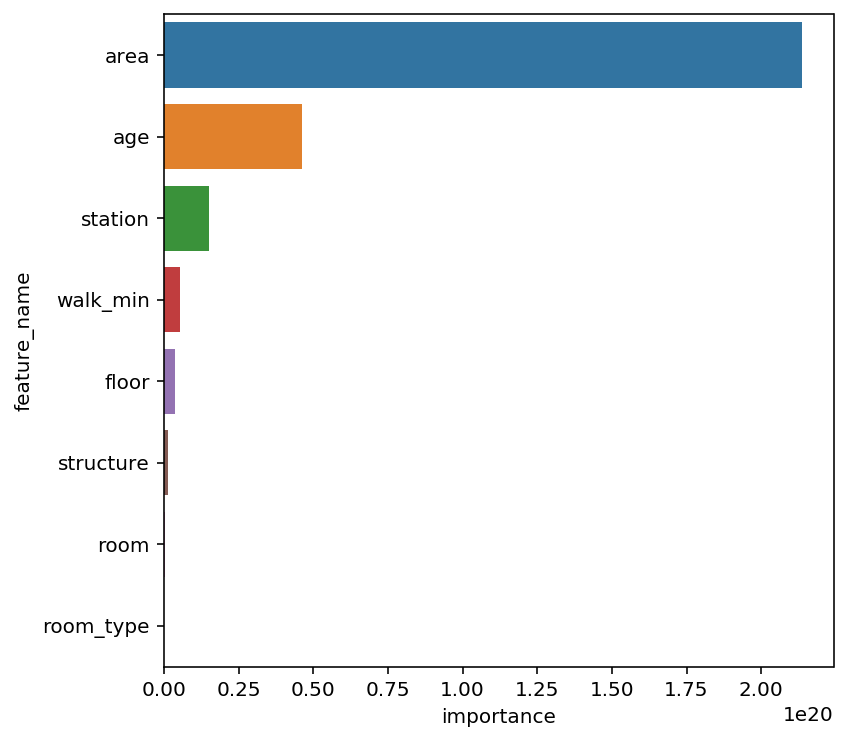

In [0]:
plt.rcParams["font.family"] = "IPAexGothic"
feature_importance = pd.DataFrame({
    'feature_name' : model.feature_name(),
    'importance' : model.feature_importance(importance_type='gain'), 
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

plt.figure(figsize = (6, 6))
sns.barplot(data=feature_importance, x='importance', y='feature_name')
plt.savefig('feature_importance.png')

## 補足用

In [0]:
# 10000イテレーションまでLightGBMを学習
def mape_func(y_pred, data):
    y_true = data.get_label()
    mape = calc_mape(y_true, y_pred)
    return 'mape', mape, False

result_dic ={}
model = lgb.train(
    params=params, 
    train_set=lgb_dataset_trn, 
    valid_sets=[lgb_dataset_trn, lgb_dataset_val], 
    feval=mape_func, 
    num_boost_round=10000, 
    verbose_eval=1000, 
    evals_result=result_dic
)

[1000]	training's rmse: 2.95614e+06	training's mape: 4.76283	valid_1's rmse: 3.85354e+06	valid_1's mape: 5.74931
[2000]	training's rmse: 2.5456e+06	training's mape: 4.26003	valid_1's rmse: 3.70824e+06	valid_1's mape: 5.63264
[3000]	training's rmse: 2.30932e+06	training's mape: 3.91434	valid_1's rmse: 3.66669e+06	valid_1's mape: 5.62127
[4000]	training's rmse: 2.13942e+06	training's mape: 3.62672	valid_1's rmse: 3.65281e+06	valid_1's mape: 5.6238
[5000]	training's rmse: 1.99874e+06	training's mape: 3.38285	valid_1's rmse: 3.65117e+06	valid_1's mape: 5.63731
[6000]	training's rmse: 1.87805e+06	training's mape: 3.16736	valid_1's rmse: 3.65789e+06	valid_1's mape: 5.64892
[7000]	training's rmse: 1.77243e+06	training's mape: 2.97908	valid_1's rmse: 3.6623e+06	valid_1's mape: 5.66245
[8000]	training's rmse: 1.68095e+06	training's mape: 2.82267	valid_1's rmse: 3.6716e+06	valid_1's mape: 5.68084
[9000]	training's rmse: 1.60361e+06	training's mape: 2.67014	valid_1's rmse: 3.68513e+06	valid_1's m

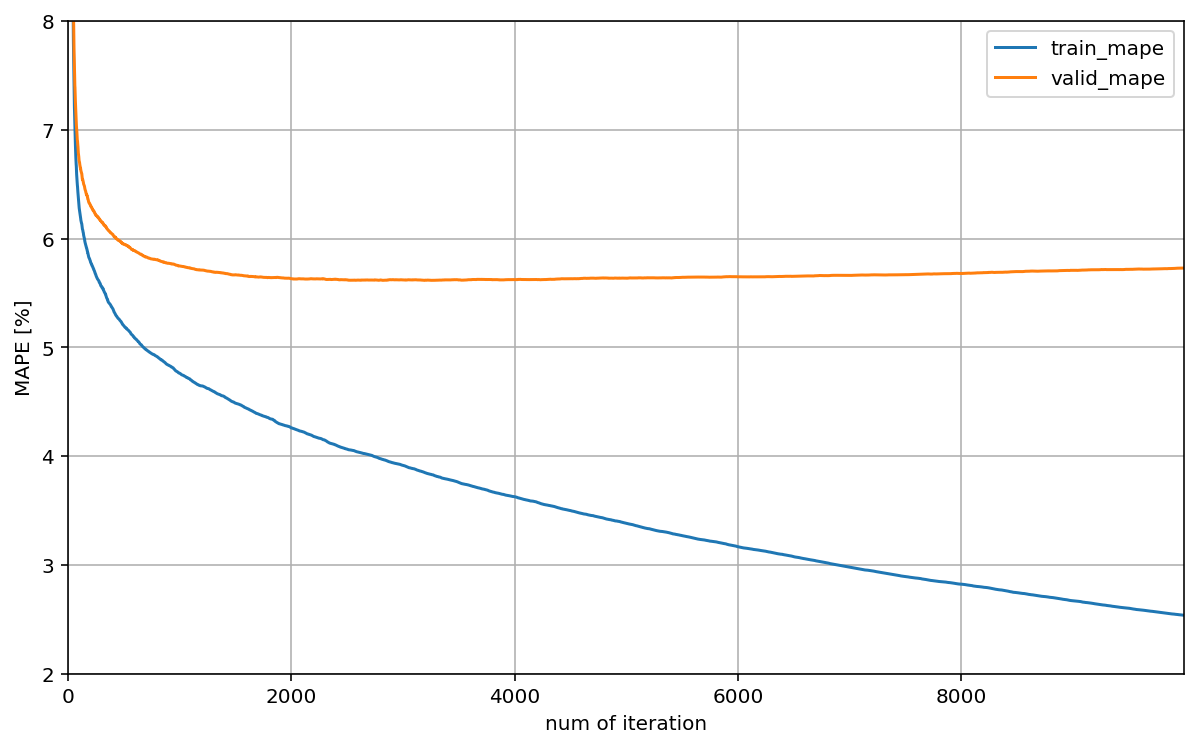

In [0]:
# 10000イテレーションまでの学習経過を表示
result_df = pd.DataFrame(result_dic['training']).add_prefix('train_').join(pd.DataFrame(result_dic['valid_1']).add_prefix('valid_'))
fig, ax = plt.subplots(figsize=(10, 6))
result_df[['train_mape', 'valid_mape']].plot(ax=ax)
ax.set_ylabel('MAPE [%]')
ax.set_xlabel('num of iteration')
ax.set_ylim(2, 8)
ax.grid()

In [0]:
data = data.append(pd.DataFrame.from_dict({
    "駅名": ["新橋"],
    "建物構造": ["SRC"],
    "徒歩分": [10],
    "専有面積": [30],
    "間取り": ["R"],
    "部屋数": [1],
    "築年": ["198001"],
    "所在階": ["5"],
    "成約価格": [-1]
})).reset_index(drop=True)
X = create_feature(data)
model.predict(X[-1:])